In [24]:
import torch
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
from os.path import exists
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
lr = 0.001 #скорость обучения
batch_size = 64
dtype = torch.float
device = torch.device('cuda') if torch.cuda.is_available() else torch.device("cpu")

In [25]:
device

device(type='cuda')

In [26]:
def loss_plot(fig, ax, train_loss, test_loss, loss_name):
    train_line = ax.plot(train_loss, color = 'black')
    test_line = ax.plot(test_loss, color = 'red')
    ax.set_xlabel('Батч')
    ax.set_ylabel(loss_name)
    ax.legend(('Тренировочная выборка', 'Тестовая выборка'))
    fig.canvas.draw()

In [27]:
download = not exists('../mnist_data')
train_set = datasets.MNIST(root='../mnist_data', train=True, download=download, transform=None)
test_set = datasets.MNIST(root='../mnist_data', train=False, download=download, transform=None)
x_train, y_train = train_set.data, train_set.data #данные являются сами себе таргером
x_test, y_test = test_set.data, test_set.data 
#переводит во float и по надобности перекидывает на видеокарту
x_train = x_train.float().to(device)
x_test = x_test.float().to(device)
y_train = x_train.float().to(device)
y_test = x_test.float().to(device)

In [28]:
x_train = x_train.reshape(-1,784)/255
x_test = x_test.reshape(-1, 784)/255
y_train = y_train.reshape(-1,784)/255
y_test = y_test.reshape(-1,784)/255

In [29]:
train_loader = DataLoader(list(zip(x_train, y_train)), batch_size=batch_size,shuffle=True)
test_loader = DataLoader(list(zip(x_test, y_test)), batch_size=batch_size,shuffle=True)

In [30]:
class Autoencoder(nn.Module):
    def __init__(self, hidden_layer = 128):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Linear(784, hidden_layer)
        self.decoder = nn.Linear(hidden_layer, 784)
        self.sig = nn.Sigmoid()
    
    def forward(self, x):
        hidden = self.sig(self.encoder(x))
        x = self.sig(self.decoder(hidden))
        return x, hidden

model = Autoencoder(64).to(device)
#Adadelta сработал намного хуже, чем Adam
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
BCEloss = torch.nn.BCELoss()


epoch 0
Train: loss: 0.26385402328360563
Test: loss: 0.22525222599506378
epoch 1
Train: loss: 0.2023842049274109
Test: loss: 0.18247903883457184
epoch 2
Train: loss: 0.1699590789737986
Test: loss: 0.1573389619588852
epoch 3
Train: loss: 0.15010109483433176
Test: loss: 0.1418772041797638
epoch 4
Train: loss: 0.1372253397968151
Test: loss: 0.13089923560619354
epoch 5
Train: loss: 0.12808377213919087
Test: loss: 0.12334004789590836
epoch 6
Train: loss: 0.12183197688605231
Test: loss: 0.1181754544377327
epoch 7
Train: loss: 0.11751123303289353
Test: loss: 0.11446721106767654
epoch 8
Train: loss: 0.11397467374102647
Test: loss: 0.11063574254512787
epoch 9
Train: loss: 0.1087319662909645
Test: loss: 0.10395663976669312
epoch 10
Train: loss: 0.10127723819887968
Test: loss: 0.09653016924858093
epoch 11
Train: loss: 0.09444741728399862
Test: loss: 0.0906805619597435
epoch 12
Train: loss: 0.08961827503338551
Test: loss: 0.08689077943563461
epoch 13
Train: loss: 0.0864176603951561
Test: loss: 0.0

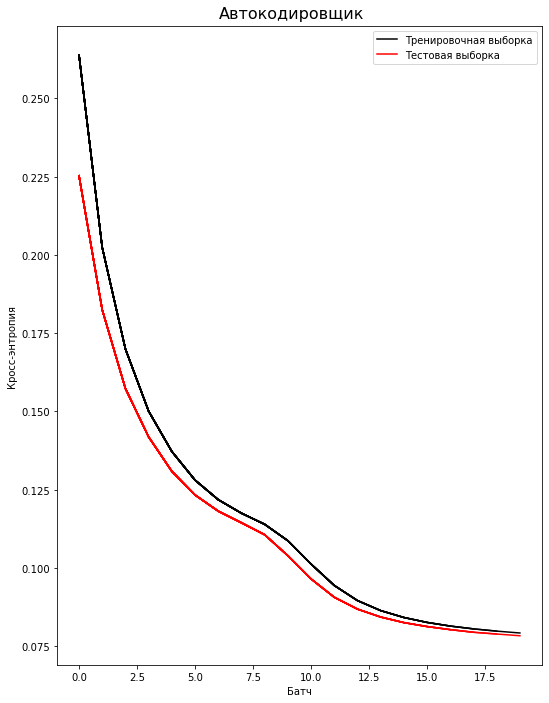

In [31]:
%matplotlib inline
fig = plt.figure(figsize=(8,10))
ax = fig.subplots(1,1)
fig.tight_layout(pad=3.0)

ax1 = ax
train_loss = []
test_loss = []
epochs = 20
for i in range(epochs):
    train_acc_tmp = 0
    train_loss_tmp = 0
    for x, y in train_loader:
        
        y_hat, _ = model(x)
        loss = BCEloss(y_hat, y)
        train_loss_tmp += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss.append(train_loss_tmp / len(train_loader))
    with torch.no_grad():
        y_hat, y_hidden  = model(x_test)
        test_loss.append(BCEloss(y_hat, y_test))
    print(f'epoch {i}')
    print(f'Train: loss: {train_loss[-1]}')
    print(f'Test: loss: {test_loss[-1]}')
    fig.suptitle('Автокодировщик', fontsize=16)
    loss_plot(fig,ax1,train_loss, test_loss, "Кросс-энтропия")

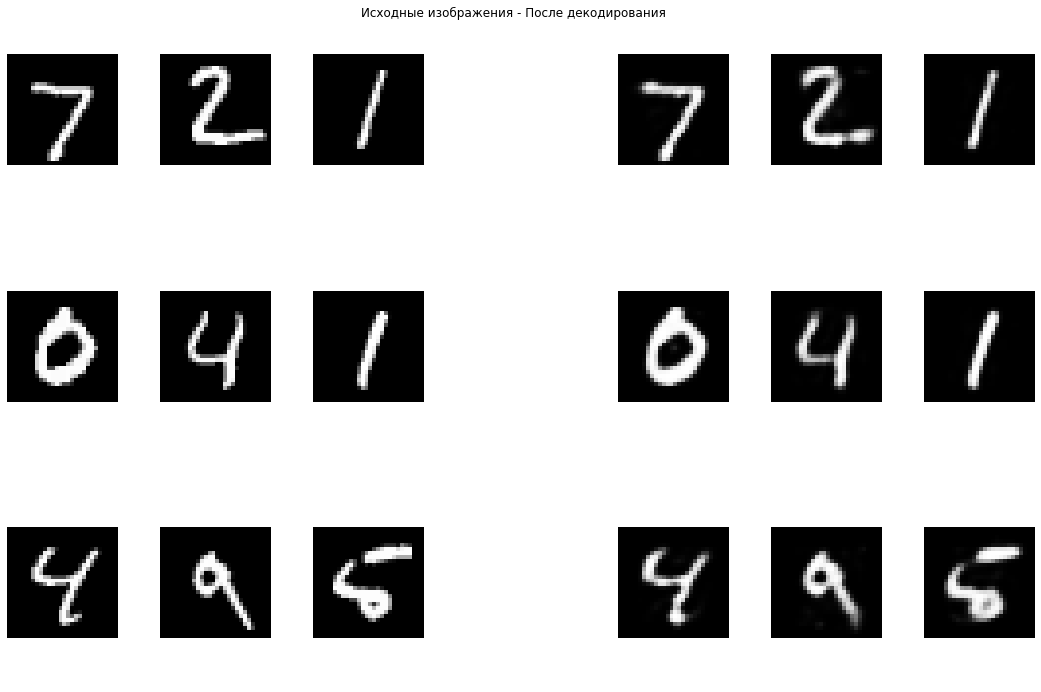

In [32]:
fig = plt.figure(figsize=(15,10))
fig.suptitle('Исходные изображения - После декодирования')
ax = fig.subplots(3,7)
fig.tight_layout()
for i in range(9):
    ax[i // 3][i % 3].axis('off')
    ax[i // 3][i % 3].imshow(x_test.cpu().numpy()[i].reshape(28, 28), cmap='gray')
for i in range(3):
    ax[i][3].axis('off')
for i in range(9):
    ax[i // 3][4 + i % 3].axis('off')
    ax[i // 3][4 + i % 3].imshow(y_hat.detach().cpu().numpy()[i].reshape(28, 28), cmap='gray')

In [33]:
def sparse_loss(hidden, rho = 0.05, beta = 1.0):
    data_rho = torch.mean(hidden, 0)
    reg_cost = - torch.mean(torch.log(data_rho / rho) * rho + torch.log((1 - data_rho) / (1 - rho)) * (1 - rho))
    return reg_cost * beta

epoch 0
Train: loss: 0.31833281445859085
Test: loss: 0.2116677314043045
epoch 1
Train: loss: 0.18532469557292425
Test: loss: 0.16165703535079956
epoch 2
Train: loss: 0.1510987412541914
Test: loss: 0.13736647367477417
epoch 3
Train: loss: 0.13286713865806044
Test: loss: 0.12361285090446472
epoch 4
Train: loss: 0.1218264103571235
Test: loss: 0.11493297666311264
epoch 5
Train: loss: 0.11445858430411261
Test: loss: 0.10884672403335571
epoch 6
Train: loss: 0.10913428036706534
Test: loss: 0.10440874099731445
epoch 7
Train: loss: 0.10509768143486875
Test: loss: 0.10108277946710587
epoch 8
Train: loss: 0.10186206678083456
Test: loss: 0.09831007570028305
epoch 9
Train: loss: 0.09924637481792649
Test: loss: 0.09618165343999863
epoch 10
Train: loss: 0.09705704238527874
Test: loss: 0.09426899999380112
epoch 11
Train: loss: 0.09521909998551106
Test: loss: 0.0926167294383049
epoch 12
Train: loss: 0.09358234280176254
Test: loss: 0.09126037359237671
epoch 13
Train: loss: 0.09220371589159915
Test: loss

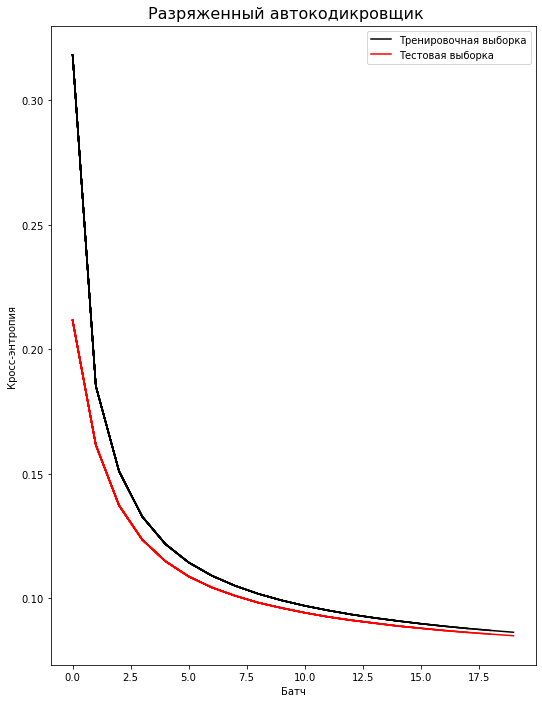

In [34]:
%matplotlib inline
#обучим разряженный автокодировщик
sparse_model = Autoencoder(128).to(device)
optimizer = torch.optim.Adam(sparse_model.parameters(), lr = lr)
BCEloss = torch.nn.BCELoss()

    
fig = plt.figure(figsize=(8,10))
ax = fig.subplots(1,1)
fig.tight_layout(pad=3.0)

ax1 = ax
train_loss = []
test_loss = []
epochs = 20
for i in range(epochs):
    train_acc_tmp = 0
    train_loss_tmp = 0
    for x, y in train_loader:
        
        y_hat, hidden = sparse_model(x)
        loss = BCEloss(y_hat, y) + sparse_loss(hidden, beta = 1)
        train_loss_tmp += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss.append(train_loss_tmp / len(train_loader))
    with torch.no_grad():
        y_hat, y_hidden  = sparse_model(x_test)
        test_loss.append(BCEloss(y_hat, y_test) + sparse_loss(y_hidden))
    print(f'epoch {i}')
    print(f'Train: loss: {train_loss[-1]}')
    print(f'Test: loss: {test_loss[-1]}')
    fig.suptitle('Разряженный автокодикровщик', fontsize=16)
    loss_plot(fig,ax1,train_loss, test_loss, "Кросс-энтропия")

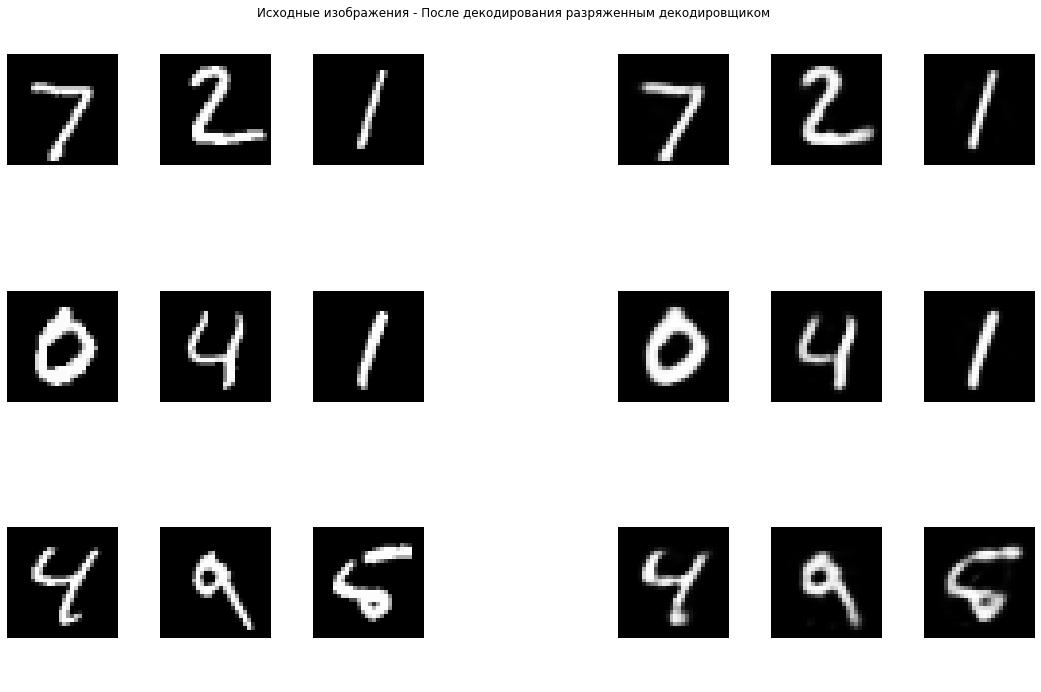

In [35]:
fig = plt.figure(figsize=(15,10))
fig.suptitle('Исходные изображения - После декодирования разряженным декодировщиком')
ax = fig.subplots(3,7)
fig.tight_layout()
for i in range(9):
    ax[i // 3][i % 3].axis('off')
    ax[i // 3][i % 3].imshow(x_test.cpu().numpy()[i].reshape(28, 28), cmap='gray')
for i in range(3):
    ax[i][3].axis('off')
for i in range(9):
    ax[i // 3][4 + i % 3].axis('off')
    ax[i // 3][4 + i % 3].imshow(y_hat.detach().cpu().numpy()[i].reshape(28, 28), cmap='gray')
    

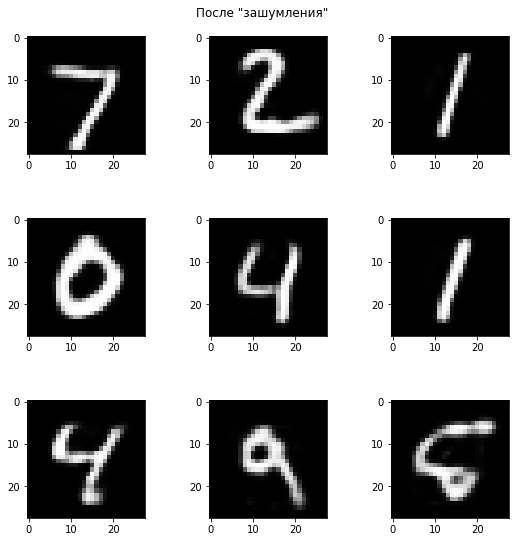

In [36]:
with torch.no_grad():
    noised = torch.nn.ReLU()(y_hidden - 0.1) + 0.1
    new_output = sparse_model.sig(sparse_model.decoder(noised))
fig = plt.figure(figsize=(8,8))
fig.suptitle('После "зашумления"')
ax = fig.subplots(3,3)
fig.tight_layout(pad=3.0)
#y_hat взят из ячейки с обучением 
for i in range(9):
    ax[i // 3][i % 3].imshow(y_hat.cpu().numpy()[i].reshape(28, 28), cmap='gray')

In [37]:
#посмотрим на фильтры разряженного автокодировщика
with torch.no_grad():
    norms = torch.sum(sparse_model.encoder.weight ** 2, 1) ** 0.5
    filters = sparse_model.encoder.weight / norms.reshape(128, 1)
    # отсебятина - нормирую значения каждого фильтра от 0 до 1
    min_val = torch.min(filters, dim = 1).values.reshape(128, 1)
    max_val = torch.max(filters, dim = 1).values.reshape(128, 1)
    filters = (filters - min_val) / (max_val - min_val)

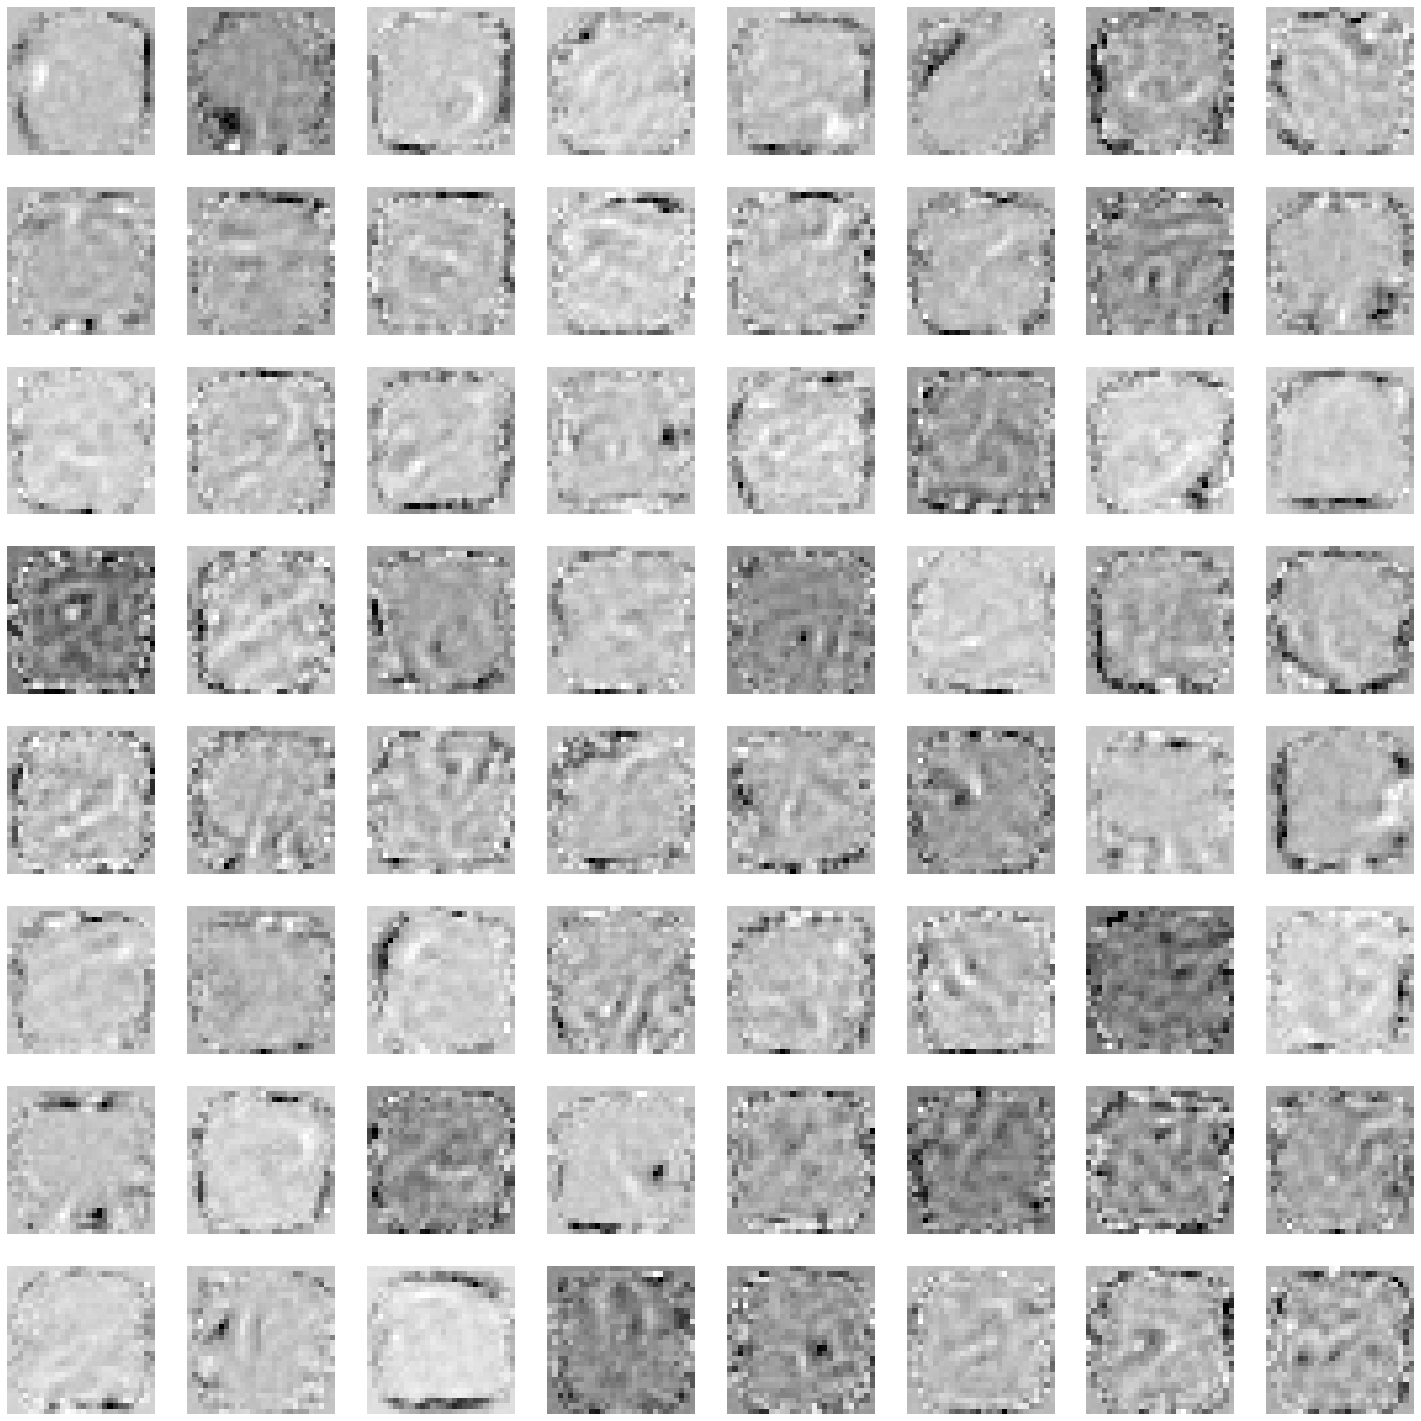

In [38]:
fig = plt.figure(figsize=(20,20))
ax = fig.subplots(8,8)
fig.tight_layout(pad=0.1)
#y_hat взят из ячейки с обучением 
for i in range(64):
    ax[i // 8][i % 8].imshow(filters.cpu().numpy()[i].reshape(28, 28), cmap='gray')
    ax[i // 8][i % 8].axis('off')

epoch 0
Train: loss: 0.2633129981821026
epoch 1
Train: loss: 0.20003377813011852
epoch 2
Train: loss: 0.16873768721816382
epoch 3
Train: loss: 0.15049543026795012
epoch 4
Train: loss: 0.1378922395980053
epoch 5
Train: loss: 0.12938193522536678
epoch 6
Train: loss: 0.12345057403418555
epoch 7
Train: loss: 0.11925897284198417
epoch 8
Train: loss: 0.11601398139397727
epoch 9
Train: loss: 0.11237374209423563
epoch 10
Train: loss: 0.10629147080692655
epoch 11
Train: loss: 0.09859834120535393
epoch 12
Train: loss: 0.09239851121804607
epoch 13
Train: loss: 0.08820657328025365
epoch 14
Train: loss: 0.08545414666567784
epoch 15
Train: loss: 0.08351691901238996
epoch 16
Train: loss: 0.08212437335330286
epoch 17
Train: loss: 0.08106866987275162
epoch 18
Train: loss: 0.08025729879419179
epoch 19
Train: loss: 0.07959293887845234


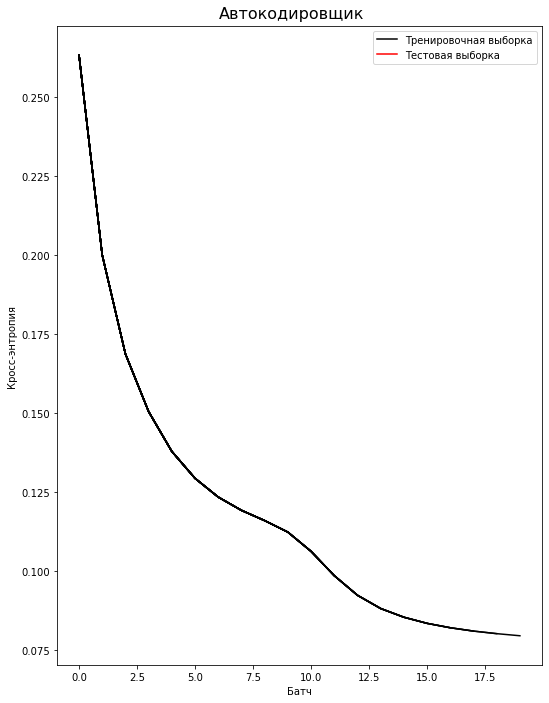

In [39]:
%matplotlib inline
fig = plt.figure(figsize=(8,10))
ax = fig.subplots(1,1)
fig.tight_layout(pad=3.0)
ax1 = ax

model = Autoencoder(64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
BCEloss = torch.nn.BCELoss()
train_loss = []

epochs = 20
noise_prob = 0.3
for i in range(epochs):
    train_acc_tmp = 0
    train_loss_tmp = 0
    for x, y in train_loader:
        noisy = x.clone()
        noise_mask = np.random.uniform(0, 1, (x.size()[0], 784)) < noise_prob
        noisy[noise_mask] = 0.0
        y_hat, _ = model(x)
        loss = BCEloss(y_hat, y)
        train_loss_tmp += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss.append(train_loss_tmp / len(train_loader))
    print(f'epoch {i}')
    print(f'Train: loss: {train_loss[-1]}')
    fig.suptitle('Автокодировщик', fontsize=16)
    loss_plot(fig,ax1,train_loss, [], "Кросс-энтропия")

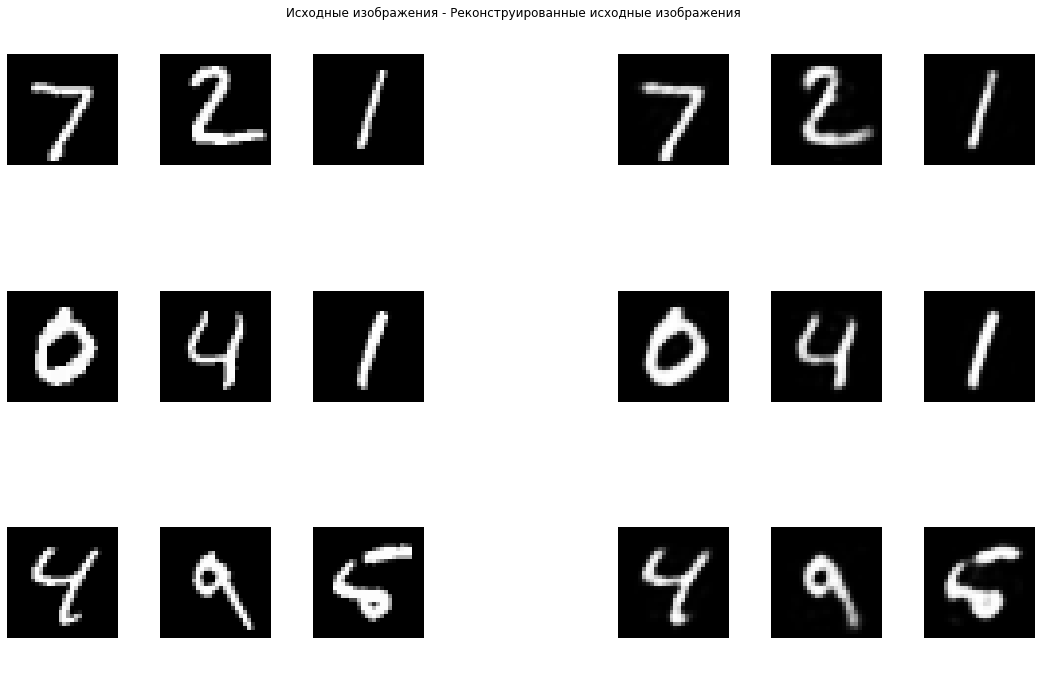

In [41]:
fig = plt.figure(figsize=(15,10))
fig.suptitle('Исходные изображения - Реконструированные исходные изображения')
ax = fig.subplots(3,7)
fig.tight_layout()
for i in range(9):
    ax[i // 3][i % 3].axis('off')
    ax[i // 3][i % 3].imshow(x_test.cpu().numpy()[i].reshape(28, 28), cmap='gray')
for i in range(3):
    ax[i][3].axis('off')
y_hat, _ = model(x_test[:9])
for i in range(9):
    ax[i // 3][4 + i % 3].axis('off')
    ax[i // 3][4 + i % 3].imshow(y_hat.detach().cpu().numpy()[i].reshape(28, 28), cmap='gray')

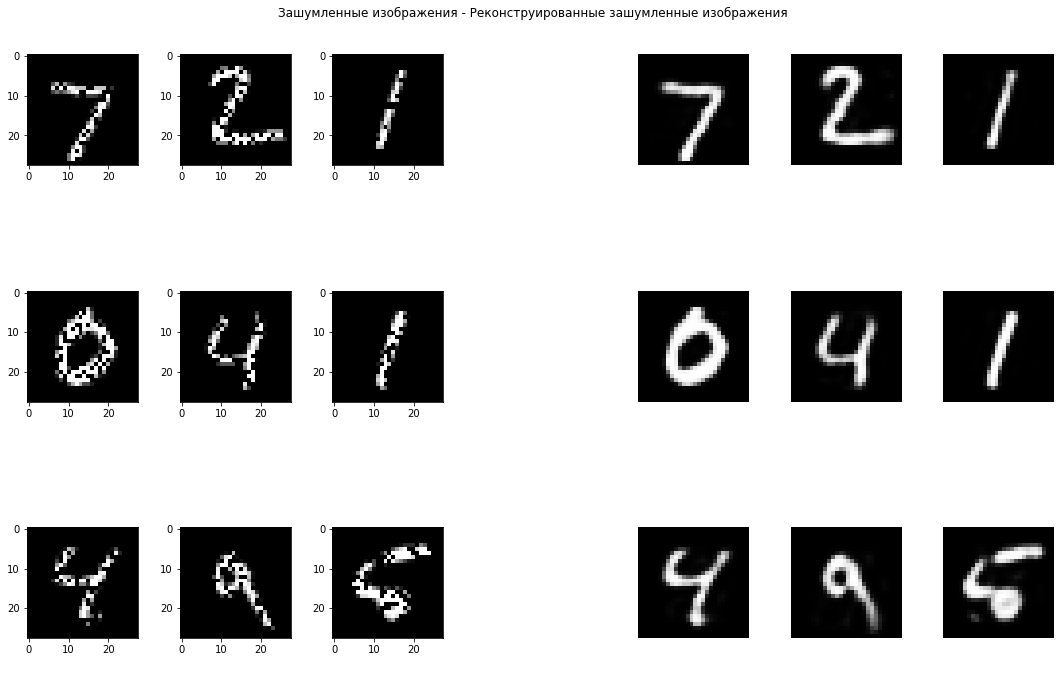

In [19]:
fig = plt.figure(figsize=(15,10))
fig.suptitle('Зашумленные изображения - Реконструированные зашумленные изображения')
ax = fig.subplots(3,7)
fig.tight_layout()

noisy = x_test[:9].clone()
noise_mask = torch.Tensor(np.random.uniform(0, 1, (9, 784)) < noise_prob).type(torch.bool)
noisy[noise_mask] = 0.0
y_hat, _ = model(noisy)
for i in range(9):
    ax[i // 3][i % 3].imshow(noisy.detach().cpu().numpy()[i].reshape(28, 28), cmap='gray')
for i in range(3):
    ax[i][3].axis('off')
for i in range(9):
    ax[i // 3][4 + i % 3].axis('off')
    ax[i // 3][4 + i % 3].imshow(y_hat.detach().cpu().numpy()[i].reshape(28, 28), cmap='gray')

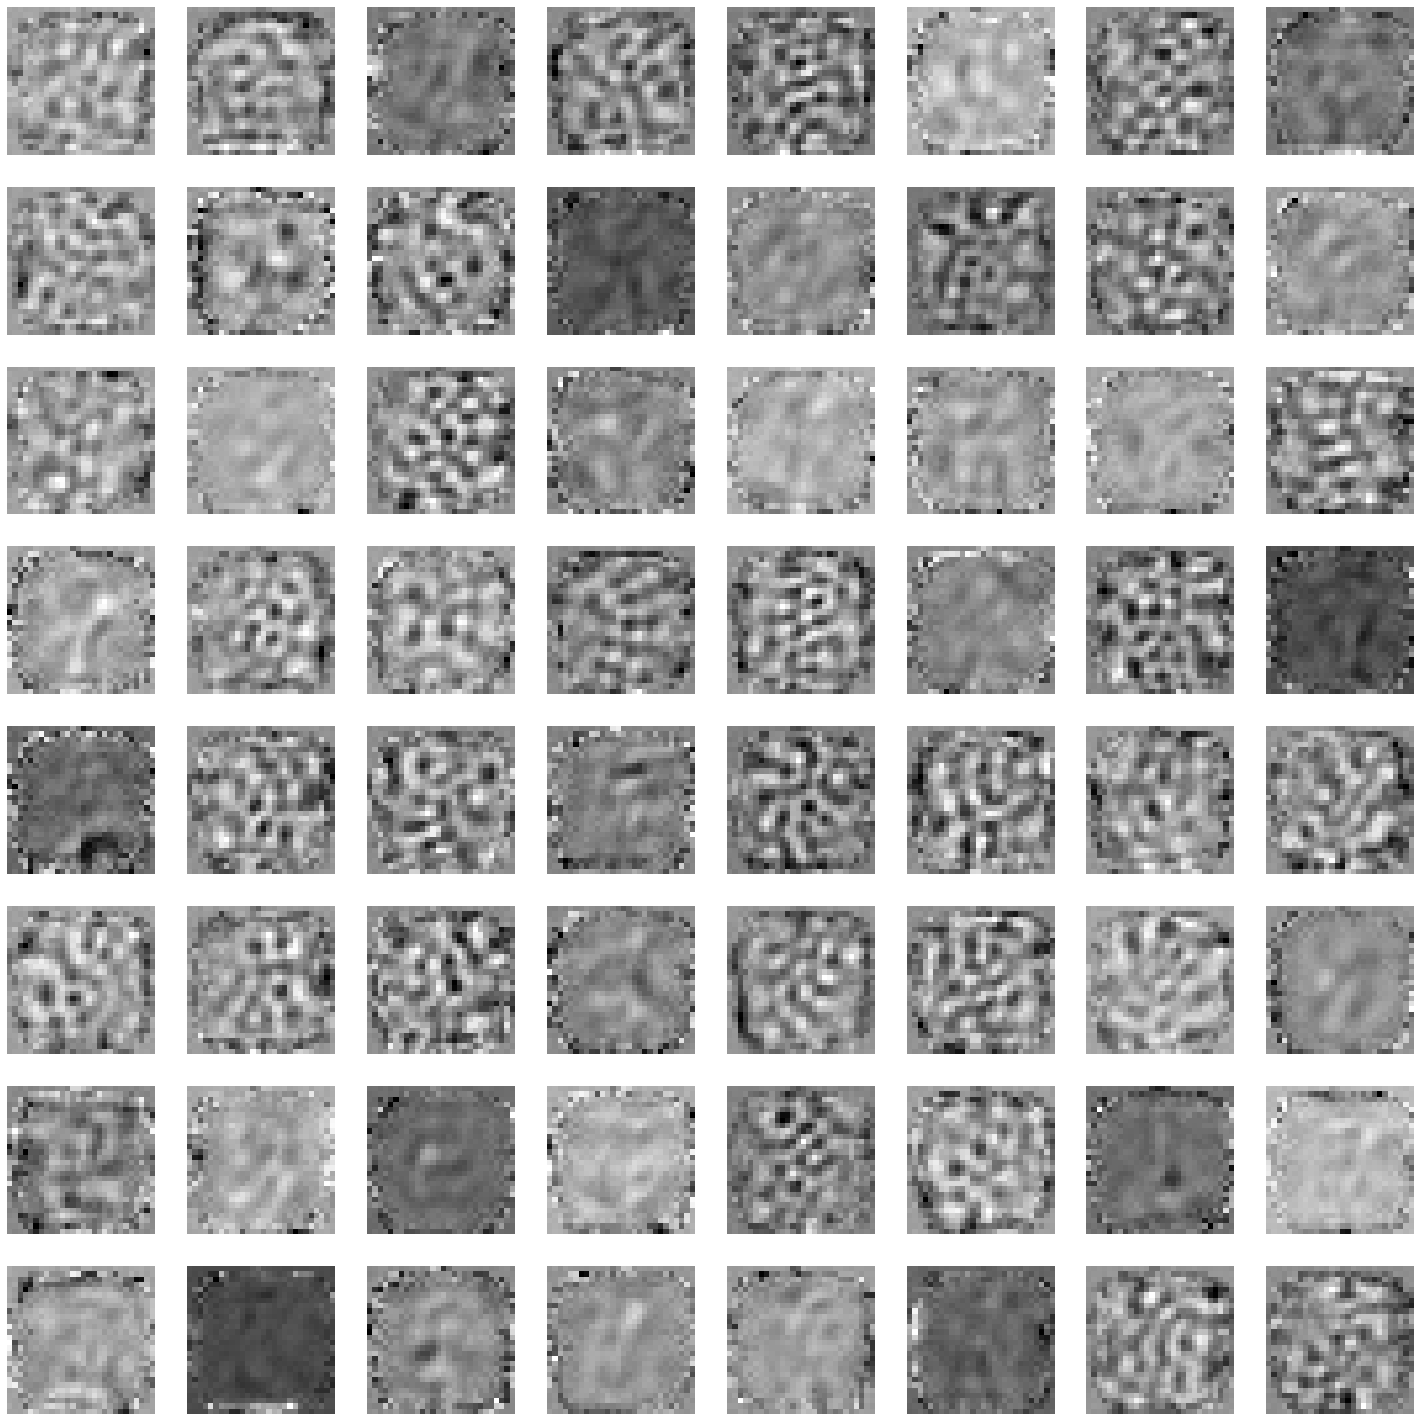

In [20]:
#посмотрим на фильтры шумоподавляющего автокодировщика
with torch.no_grad():
    norms = torch.sum(model.encoder.weight ** 2, 1) ** 0.5
    filters = model.encoder.weight / norms.reshape(64, 1)
    # отсебятина - нормирую значения каждого фильтра от 0 до 1
    min_val = torch.min(filters, dim = 1).values.reshape(64, 1)
    max_val = torch.max(filters, dim = 1).values.reshape(64, 1)
    filters = (filters - min_val) / (max_val - min_val)

fig = plt.figure(figsize=(20,20))
ax = fig.subplots(8,8)
fig.tight_layout(pad=0.1)
#y_hat взят из ячейки с обучением 
for i in range(64):
    ax[i // 8][i % 8].imshow(filters.cpu().numpy()[i].reshape(28, 28), cmap='gray')
    ax[i // 8][i % 8].axis('off')

epoch 0
Train: loss: 0.21571406571150842
Test: loss: 0.13212290406227112
epoch 1
Train: loss: 0.09992746041337056
Test: loss: 0.08303649723529816
epoch 2
Train: loss: 0.07567067839888367
Test: loss: 0.06964763253927231
epoch 3
Train: loss: 0.06857444124737147
Test: loss: 0.06692266464233398
epoch 4
Train: loss: 0.06653529048553788
Test: loss: 0.06541495025157928
epoch 5
Train: loss: 0.06520049864930638
Test: loss: 0.06429643929004669
epoch 6
Train: loss: 0.06419424394538789
Test: loss: 0.06344207376241684
epoch 7
Train: loss: 0.06340187160905872
Test: loss: 0.06272655725479126
epoch 8
Train: loss: 0.06274352846607598
Test: loss: 0.06214125081896782
epoch 9
Train: loss: 0.062223512397360195
Test: loss: 0.061699509620666504
epoch 10
Train: loss: 0.06181723159799444
Test: loss: 0.06132374703884125
epoch 11
Train: loss: 0.06146606509841836
Test: loss: 0.06101077422499657
epoch 12
Train: loss: 0.061185194437564816
Test: loss: 0.06076008453965187
epoch 13
Train: loss: 0.060959188505880106
Te

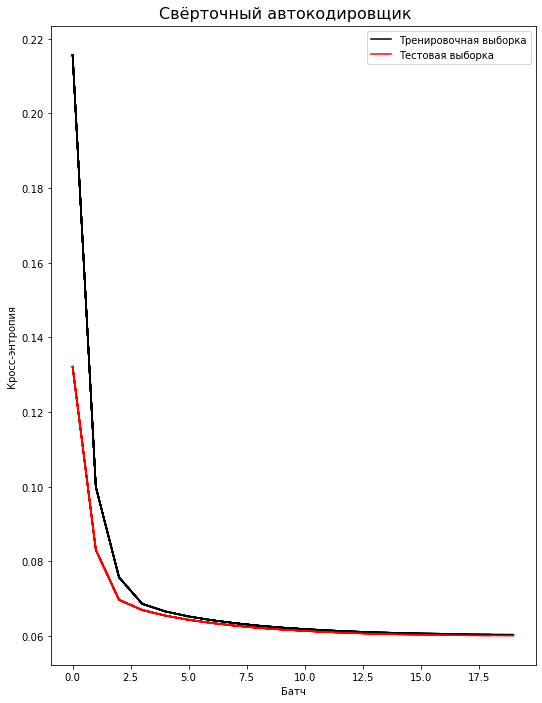

In [21]:
x_train, y_train = train_set.data, train_set.data
x_test, y_test = test_set.data, test_set.data 
x_train = x_train.float().to(device)
x_test = x_test.float().to(device)
y_train = y_train.float().to(device)
y_test = y_test.float().to(device)
x_train = x_train.reshape(-1,1,28, 28)/255
x_test = x_test.reshape(-1,1, 28, 28)/255
y_train = y_train.reshape(-1,1,28, 28)/255
y_test = y_test.reshape(-1,1,28, 28)/255
train_loader = DataLoader(list(zip(x_train, y_train)), batch_size=batch_size,shuffle=True)
test_loader = DataLoader(list(zip(x_test, y_test)), batch_size=batch_size,shuffle=True)

class Conv_autoencoder(nn.Module):
    def __init__(self, hidden_layer = 4):
        super(Conv_autoencoder, self).__init__()
        self.encoder = nn.Conv2d(1, hidden_layer, kernel_size=5, padding = 2)
        self.decoder = nn.ConvTranspose2d(hidden_layer, 1, kernel_size=5, padding = 2)
        self.sig = nn.Sigmoid()
    
    def forward(self, x):
        hidden = self.sig(self.encoder(x))
        x = self.sig(self.decoder(hidden))
        return x, hidden

model = Conv_autoencoder(4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
BCEloss = torch.nn.BCELoss()

%matplotlib inline
fig = plt.figure(figsize=(8,10))
ax = fig.subplots(1,1)
fig.tight_layout(pad=3.0)

ax1 = ax
train_loss = []
test_loss = []
epochs = 20
for i in range(epochs):
    train_acc_tmp = 0
    train_loss_tmp = 0
    for x, y in train_loader:
        
        y_hat, _ = model(x)
        loss = BCEloss(y_hat, y)
        train_loss_tmp += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss.append(train_loss_tmp / len(train_loader))
    with torch.no_grad():
        y_hat, y_hidden  = model(x_test)
        test_loss.append(BCEloss(y_hat, y_test))
    print(f'epoch {i}')
    print(f'Train: loss: {train_loss[-1]}')
    print(f'Test: loss: {test_loss[-1]}')
    fig.suptitle('Свёрточный автокодировщик', fontsize=16)
    loss_plot(fig,ax1,train_loss, test_loss, "Кросс-энтропия")


epoch 0
Train: loss: 0.6159924560391319
Test: loss: 0.5099448561668396
epoch 1
Train: loss: 0.45588777063370767
Test: loss: 0.42177313566207886
epoch 2
Train: loss: 0.40372736221437516
Test: loss: 0.39658424258232117
epoch 3
Train: loss: 0.3901517905596731
Test: loss: 0.3915673792362213
epoch 4
Train: loss: 0.38782370011054124
Test: loss: 0.3911392092704773
epoch 5
Train: loss: 0.38764932341794217
Test: loss: 0.39114999771118164
epoch 6
Train: loss: 0.3876431269495726
Test: loss: 0.39116236567497253
epoch 7
Train: loss: 0.38764195900354814
Test: loss: 0.3911703824996948
epoch 8
Train: loss: 0.38763465857836227
Test: loss: 0.39114612340927124
epoch 9
Train: loss: 0.387651952535613
Test: loss: 0.39115381240844727
epoch 10
Train: loss: 0.17706723286033565
Test: loss: 0.06266815960407257
epoch 11
Train: loss: 0.06229587664990537
Test: loss: 0.06143957003951073
epoch 12
Train: loss: 0.061427292670172925
Test: loss: 0.060887403786182404
epoch 13
Train: loss: 0.06087535412422121
Test: loss: 0

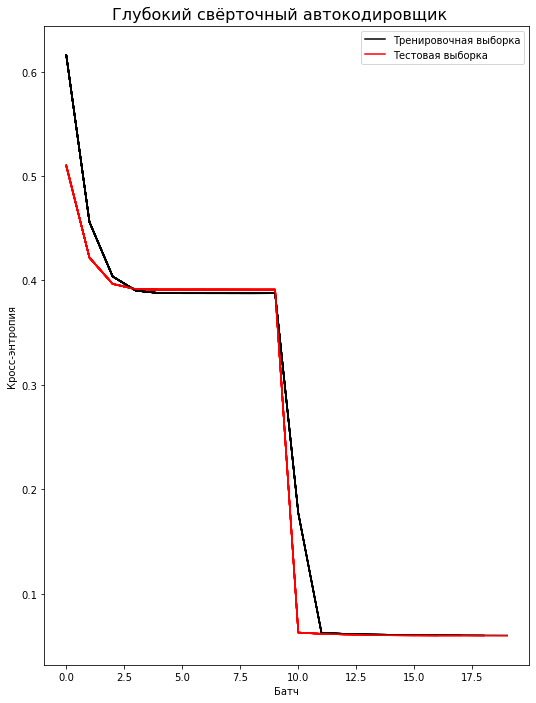

In [22]:
class Deep_conv_autoencoder(nn.Module):
    def __init__(self):
        super(Deep_conv_autoencoder, self).__init__()
        self.encoder1 = nn.Conv2d(1, 4, kernel_size=5, padding = 2)
        self.encoder2 = nn.Conv2d(4, 16, kernel_size=5, padding = 2)
        self.decoder2 = nn.ConvTranspose2d(16, 4, kernel_size=5, padding = 2)
        self.decoder1 = nn.ConvTranspose2d(4, 1, kernel_size=5, padding = 2)
        self.sig = nn.Sigmoid()
        self.rl = nn.ReLU()
    
    def forward(self, x):
        x = self.rl(self.encoder1(x))
        x = self.rl(self.encoder2(x))
        x = self.rl(self.decoder2(x))
        x = self.sig(self.decoder1(x))
        return x

model = Deep_conv_autoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
BCEloss = torch.nn.BCELoss()

%matplotlib inline
fig = plt.figure(figsize=(8,10))
ax = fig.subplots(1,1)
fig.tight_layout(pad=3.0)

ax1 = ax
train_loss = []
test_loss = []
epochs = 20
for i in range(epochs):
    train_acc_tmp = 0
    train_loss_tmp = 0
    for x, y in train_loader:
        
        y_hat = model(x)
        loss = BCEloss(y_hat, y)
        train_loss_tmp += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss.append(train_loss_tmp / len(train_loader))
    with torch.no_grad():
        y_hat   = model(x_test)
        test_loss.append(BCEloss(y_hat, y_test))
    print(f'epoch {i}')
    print(f'Train: loss: {train_loss[-1]}')
    print(f'Test: loss: {test_loss[-1]}')
    fig.suptitle('Глубокий свёрточный автокодировщик', fontsize=16)
    loss_plot(fig,ax1,train_loss, test_loss, "Кросс-энтропия")

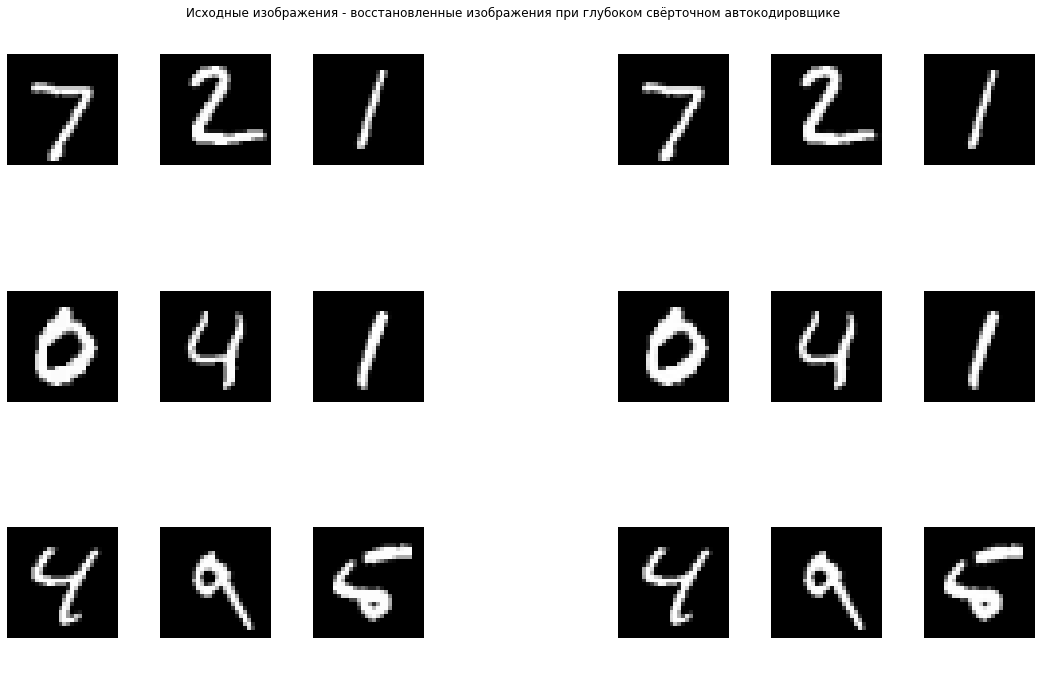

In [23]:
fig = plt.figure(figsize=(15,10))
fig.suptitle('Исходные изображения - восстановленные изображения при глубоком свёрточном автокодировщике')
ax = fig.subplots(3,7)
fig.tight_layout()
for i in range(9):
    ax[i // 3][i % 3].axis('off')
    ax[i // 3][i % 3].imshow(x_test.cpu().numpy()[i].reshape(28, 28), cmap='gray')
for i in range(3):
    ax[i][3].axis('off')
for i in range(9):
    ax[i // 3][4 + i % 3].axis('off')
    ax[i // 3][4 + i % 3].imshow(y_hat.cpu().numpy()[i].reshape(28, 28), cmap='gray')